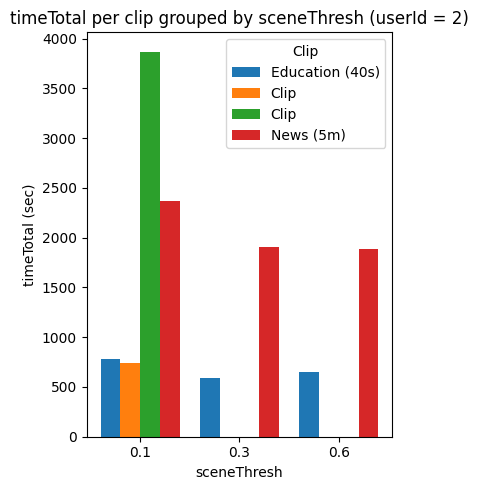

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# =========================
# CONFIG
# =========================
CSV_PATH = "stats_data.csv"
FILTER_DATETIME = "2025-12-18 00:00:00"
TARGET_THRESH = [0.1, 0.3, 0.6]
TARGET_USER_ID = 2

CLIP_NAME_MAP = {
    "https://www.youtube.com/shorts/Mr0Fce0E7TQ": "Education (40s)",
    "https://www.youtube.com/watch?v=lvin7ohQe60": "News (5m)"
}

# =========================
# LOAD DATA
# =========================
df = pd.read_csv(CSV_PATH)
df["startedAt"] = pd.to_datetime(df["startedAt"], errors="coerce")

# =========================
# FILTER DATA
# =========================
filtered_df = df[
    (df["userId"] == TARGET_USER_ID) &
    (df["sceneThresh"].isin(TARGET_THRESH)) &
    (df["startedAt"] >= FILTER_DATETIME)
].dropna(subset=["timeTotal"])

# =========================
# PREPARE AXIS
# =========================
thresh_labels = [str(t) for t in TARGET_THRESH]
x = np.arange(len(thresh_labels))   # [0, 1, 2]

groups = list(filtered_df.groupby("youtubeUrl"))
bar_width = 0.8 / len(groups)

# =========================
# PLOT
# =========================
plt.figure(figsize=(4, 5))

for i, (url, group) in enumerate(groups):
    clip_name = CLIP_NAME_MAP.get(url, "Clip")

    # map thresh -> x position
    positions = [
        x[thresh_labels.index(str(t))] + i * bar_width
        for t in group["sceneThresh"]
    ]

    plt.bar(
        positions,
        group["timeTotal"],
        width=bar_width,
        label=clip_name
    )

plt.xticks(
    x + bar_width * (len(groups) - 1) / 2,
    thresh_labels
)

plt.xlabel("sceneThresh")
plt.ylabel("timeTotal (sec)")
plt.title("timeTotal per clip grouped by sceneThresh (userId = 2)")
plt.legend(title="Clip")
plt.tight_layout()
plt.show()


In [4]:
TARGET_THRESH = 0.4

df_f = df[
    (df["userId"] == TARGET_USER_ID) &
    (df["sceneThresh"] == TARGET_THRESH) &
    (df["durationSec"].between(200, 360))
].dropna(subset=[
    "transcriptWord",
    "timeSpeechtoTextSec",
    "timeTotal",
    "durationSec"
])


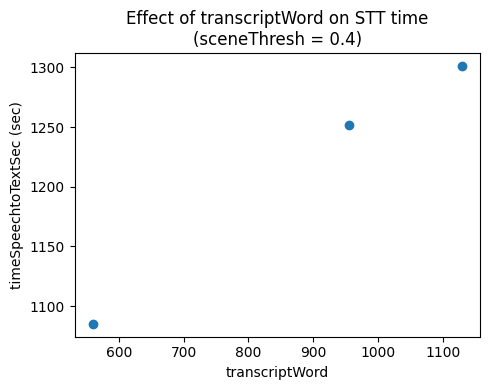

In [5]:
plt.figure(figsize=(5, 4))

plt.scatter(
    df_f["transcriptWord"],
    df_f["timeSpeechtoTextSec"]
)

plt.xlabel("transcriptWord")
plt.ylabel("timeSpeechtoTextSec (sec)")
plt.title("Effect of transcriptWord on STT time\n(sceneThresh = 0.4)")
plt.tight_layout()
plt.show()


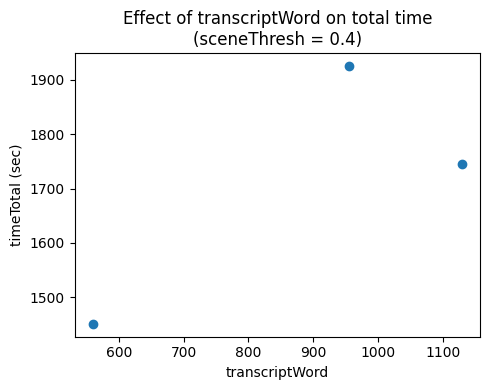

In [ ]:
plt.figure(figsize=(5, 4))

plt.scatter(
    df_f["transcriptWord"],
    df_f["timeTotal"]
)

plt.xlabel("transcriptWord")
plt.ylabel("timeTotal (sec)")
plt.title("Effect of transcriptWord on total time\n(sceneThresh = 0.4)")
plt.tight_layout()
plt.show()


Total clips for userId=6: 297
Categories: ['การออกกำลังกาย' 'สปอย' 'พอดแคสต์พัฒนาตนเอง' 'สารคดี' 'ข่าว']


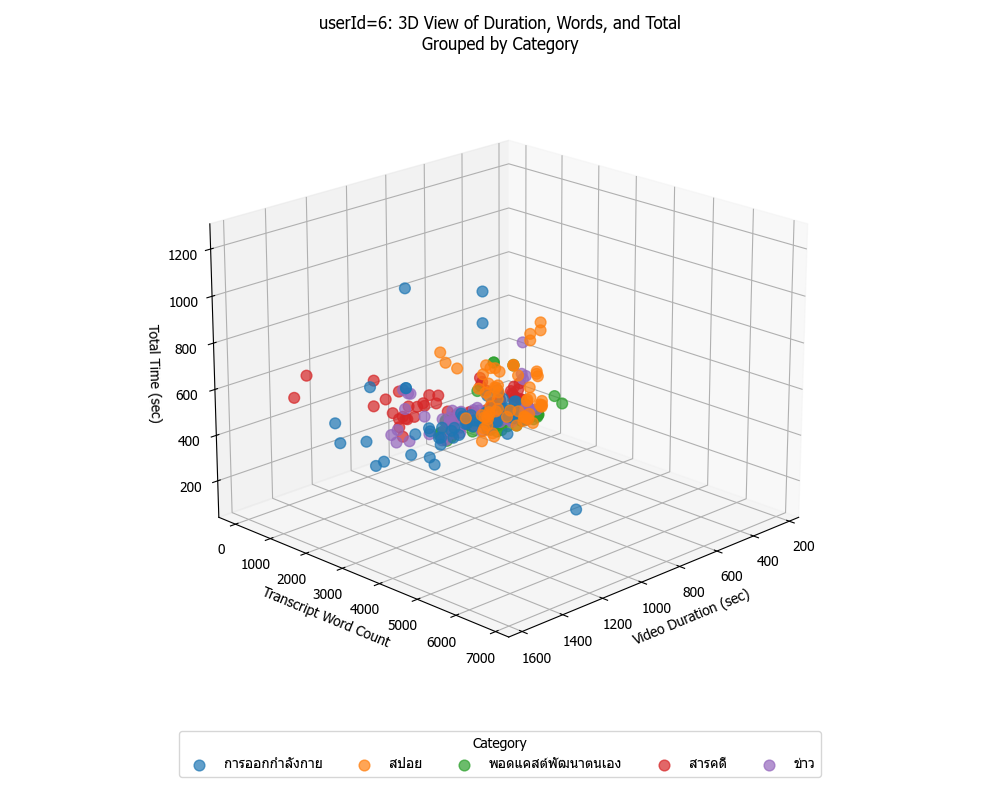

In [1]:
%matplotlib widget
# =========================
# ANALYSIS: userId = 6
# 3D Scatter Plot: transcriptWord, durationSec, timeTotal
# =========================
import pandas as pd
import matplotlib.pyplot as plt
import re
from mpl_toolkits.mplot3d import Axes3D

# ตั้งค่าฟอนต์ภาษาไทย
plt.rcParams['font.family'] = 'Tahoma'

# --- Load Data ---
stats_df = pd.read_csv('stats_data.csv')
mapper_df = pd.read_excel('75clip_mapper.xlsx')

userId = 6

# --- Filter userId = 6 and status = DONE ---
df_user6 = stats_df[(stats_df['userId'] == userId) & (stats_df['status'] == 'DONE')].copy()

# --- Normalize YouTube URL for joining ---
def normalize_url(url):
    if pd.isna(url):
        return None
    patterns = [
        r'(?:v=|youtu\.be/)([a-zA-Z0-9_-]{11})',
        r'(?:embed/)([a-zA-Z0-9_-]{11})',
        r'(?:shorts/)([a-zA-Z0-9_-]{11})'
    ]
    for pattern in patterns:
        match = re.search(pattern, str(url))
        if match:
            return match.group(1)
    return None

df_user6['video_id'] = df_user6['youtubeUrl'].apply(normalize_url)
mapper_df['video_id'] = mapper_df['YoutubeUrl'].apply(normalize_url)

# --- Merge with mapper ---
df_merged = df_user6.merge(
    mapper_df[['video_id', 'Category', 'Duration(min)']],
    on='video_id',
    how='left'
)

# --- Filter valid data ---
df_merged = df_merged.dropna(subset=['transcriptWord', 'durationSec', 'timeTotal', 'Category'])

print(f'Total clips for userId=6: {len(df_merged)}')
print(f'Categories: {df_merged["Category"].unique()}')

# =========================
# 3D SCATTER PLOT (แก้ไขแล้ว)
# =========================
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

categories = df_merged['Category'].unique()
colors = plt.cm.tab10(range(len(categories)))

for i, cat in enumerate(categories):
    subset = df_merged[df_merged['Category'] == cat]
    ax.scatter(
        subset['durationSec'],
        subset['transcriptWord'],
        subset['timeTotal'],
        c=[colors[i]],
        label=cat,
        alpha=0.7,
        s=60
    )

ax.set_xlabel('Video Duration (sec)')
ax.set_ylabel('Transcript Word Count')
ax.set_zlabel('Total Time (sec)')
ax.set_title('userId=6: 3D View of Duration, Words, and Total\nGrouped by Category')

# ย้าย legend ออกไปด้านล่าง
fig.legend(title='Category', loc='lower center', ncol=6, bbox_to_anchor=(0.5, 0.02))

# ปรับมุมมองให้เห็นแกน z ชัดขึ้น
ax.view_init(elev=20, azim=45)

plt.tight_layout(rect=[0, 0.1, 1, 1])  # เว้นที่ด้านล่างสำหรับ legend
plt.show()

In [ ]:
import plotly.express as px

# สร้าง 2D Scatter Plot แบบ interactive
fig = px.scatter(
    df_merged,
    x='durationSec',
    y='timeTotal',
    color='Category',
    hover_data=['transcriptWord', 'whisperTemp', 'youtubeUrl'],  # เพิ่ม whisperTemp
    title='userId=6: Video Duration vs Total Time<br>(Hover to see Transcript Word Count)',
    labels={
        'durationSec': 'ความยาวคลิป (sec)',
        'timeTotal': 'เวลาที่ใช้สรุปทั้งหมด (sec)',
        'transcriptWord': 'จำนวนคำ',
        'whisperTemp': 'Whisper Temp'  
    }
)

# ปรับขนาดและ style
fig.update_traces(marker=dict(size=10, opacity=0.7))
fig.update_layout(
    width=900,
    height=600,
    legend_title_text='Category',
    hovermode='closest'
)

fig.show()

### filter by category, whisperTemp, duration (100group) อยากรู้ว่า ยิ่ง transcript word มาก มันส่งผลต่อ total time ไหม

In [ ]:
คิด trend โดย sort x เช่น(1, 3, 5) แล้วดูว่า ค่า มีส่วนต่าง(y2 - y1, y3 - y2)เท่าไร ถ้าเป็น + คู่ = increadsing 
ถ้าเป็น - คู่ = decreasing

In [56]:
df["duration_group"] = (df["durationSec"] / 300).round() * 300
import numpy as np

def trend_direction(x, y):
    # x = transcriptWord, y = totalTime
    order = np.argsort(x)
    y_sorted = y[order]

    if np.all(np.diff(y_sorted) > 0):
        return "increasing"
    elif np.all(np.diff(y_sorted) < 0):
        return "decreasing"
    else:
        return "mixed"

results = []

group_cols = ["Category", "whisperTemp", "duration_group"]

for keys, g in df.groupby(group_cols):
    if len(g) == 3:
        trend = trend_direction(
            g["transcriptWord"].values,
            g["timeTotal"].values
        )
        results.append({
            "Category": keys[0],
            "Temp": keys[1],
            "Duration": keys[2],
            "trend": trend
        })

import pandas as pd

trend_df = pd.DataFrame(results)

trend_df.groupby(["Category", "Temp"])["trend"].value_counts(normalize=True)

import plotly.express as px

summary = (
    trend_df
    .assign(is_increasing=lambda x: x["trend"] == "increasing")
    .groupby(["Category", "Temp"])["is_increasing"]
    .mean()
    .reset_index()
)

fig = px.imshow(
    summary.pivot(
        index="Category",
        columns="Temp",
        values="is_increasing"
    ),
    title="Proportion of Groups Showing Increasing Total Time<br>with Transcript Word Count"
)

fig.show()

ผล: word มาก ส่งผลให้เวลาเพิ่มจะเป็นจริงแค่ พอสแคสต์ แต่ category พบว่าไม่จำเป็นเสมอไป หรือไม่ก็ ข้อมูลไม่เพียงพอ

### งั้นลองเปลี่ยนจาก total time -> speech to text time

In [41]:
# 1) สร้าง duration group (5,10,15,20,25 นาที)
df["duration_group"] = (df["durationSec"] / 300).round() * 300

import numpy as np

# 2) ฟังก์ชันดูแนวโน้ม (เหมือนเดิม)
def trend_direction(x, y):
    # x = transcriptWord, y = timeSpeechtoTextSec
    order = np.argsort(x)
    y_sorted = y[order]

    if np.all(np.diff(y_sorted) > 0):
        return "increasing"
    elif np.all(np.diff(y_sorted) < 0):
        return "decreasing"
    else:
        return "mixed"

# 3) คำนวณ trend ต่อ group
results = []

group_cols = ["Category", "whisperTemp", "duration_group"]

for keys, g in df.groupby(group_cols):
    # ต้องมีครบ 3 ตัว และ STT time ไม่เป็น NaN
    if len(g) == 3 and g["timeSpeechtoTextSec"].notna().all():
        trend = trend_direction(
            g["transcriptWord"].values,
            g["timeSpeechtoTextSec"].values
        )
        results.append({
            "Category": keys[0],
            "Temp": keys[1],
            "Duration": keys[2],
            "trend": trend
        })

import pandas as pd

trend_df = pd.DataFrame(results)

# 4) ดูสัดส่วน trend (optional debug)
trend_df.groupby(["Category", "Temp"])["trend"].value_counts(normalize=True)
import plotly.express as px

summary = (
    trend_df
    .assign(is_increasing=lambda x: x["trend"] == "increasing")
    .groupby(["Category", "Temp"])["is_increasing"]
    .mean()
    .reset_index()
)

fig = px.imshow(
    summary.pivot(
        index="Category",
        columns="Temp",
        values="is_increasing"
    ),
    title="Proportion of Groups Showing Increasing STT Time<br>with Transcript Word Count"
)

fig.show()


ผล: มีแนวโน้มว่า ยิ่ง transcriptWord มากขึ้น ยิ่ง timeSpeechtoTextSec มากขึ้นตาม ในหลายกลุ่ม

### whisper temp มากๆ มันทำให้สรุปเร็วขึ้นหรอ

In [57]:
from scipy.stats import spearmanr

results = []

for (cat, dur), g in df.groupby(["Category", "duration_group"]):
    if g["whisperTemp"].nunique() >= 3:
        rho, _ = spearmanr(
            g["whisperTemp"],
            g["timeTotal"]
        )
        results.append({
            "Category": cat,
            "Duration": dur,
            "rho": rho
        })

rho_df = pd.DataFrame(results)


In [58]:
summary = (
    rho_df
    .assign(is_faster=lambda x: x["rho"] < 0)
    .groupby("Category")["is_faster"]
    .mean()
)

print(summary)

Category
การออกกำลังกาย        1.0
ข่าว                  0.8
พอดแคสต์พัฒนาตนเอง    0.8
สปอย                  0.8
สารคดี                0.8
Name: is_faster, dtype: float64


ใน Category = การออกกำลังกาย 100% ของ duration เมื่อ whisperTemp เพิ่มขึ้น → total time มีแนวโน้ม “ลดลง”
ใน Category อื่น ๆ 80% ของ duration มีแนวโน้มไปทาง “เร็วขึ้น”

In [61]:
df = df_merged.copy()

# duration group (± 5 นาที)
df["duration_group"] = (
    df["durationSec"] / 300
).round().astype(int) * 300

# normalize time
df["time_per_1k_word"] = (
    df["timeTotal"] / df["transcriptWord"] * 1000
)


In [62]:
from scipy.stats import spearmanr

results_norm = []

for (cat, dur), g in df.groupby(["Category", "duration_group"]):
    if g["whisperTemp"].nunique() >= 3:
        rho, _ = spearmanr(
            g["whisperTemp"],
            g["time_per_1k_word"]
        )
        results_norm.append({
            "Category": cat,
            "Duration": dur,
            "rho_norm": rho
        })

rho_norm_df = pd.DataFrame(results_norm)

summary_norm = (
    rho_norm_df
    .assign(is_faster=lambda x: x["rho_norm"] < 0)
    .groupby("Category")["is_faster"]
    .mean()
)

print(summary_norm)


Category
การออกกำลังกาย        0.4
ข่าว                  1.0
พอดแคสต์พัฒนาตนเอง    0.8
สปอย                  0.8
สารคดี                1.0
Name: is_faster, dtype: float64


ข่าว, สารคดี
→ whisperTemp สูง ทำให้ประมวลผลเร็วขึ้นจริง (ทุก duration)
พอดแคสต์พัฒนาตนเอง, สปอย
→ ส่วนใหญ่เร็วขึ้น แต่ไม่สม่ำเสมอทุก duration
การออกกำลังกาย
→ ไม่พบผลชัดเจน

แต่ด้านบนมันคิดเทียบกับ time total ซึ่งจริงๆควรเทียบกับ timeSpeechtoTextSec

In [64]:
import pandas as pd
import numpy as np

df = df_merged.copy()

# จัดกลุ่ม duration (≈ 5,10,15,20,25 นาที)
df["duration_group"] = (
    df["durationSec"] / 300
).round().astype(int) * 300

# normalize: เวลา STT ต่อ 1,000 คำ
df["stt_time_per_1k_word"] = (
    df["timeSpeechtoTextSec"] / df["transcriptWord"] * 1000
)


In [67]:
from scipy.stats import spearmanr

results_norm = []

for (cat, dur), g in df.groupby(["Category", "duration_group"]):
    if g["whisperTemp"].nunique() >= 3:
        rho, _ = spearmanr(
            g["whisperTemp"],
            g["stt_time_per_1k_word"]
        )
        results_norm.append({
            "Category": cat,
            "Duration": dur,
            "rho_norm": rho
        })

rho_norm_df = pd.DataFrame(results_norm)
summary_norm = (
    rho_norm_df
    .assign(is_faster=lambda x: x["rho_norm"] < 0)
    .groupby("Category")["is_faster"]
    .mean()
)

print(summary_norm)

Category
การออกกำลังกาย        0.4
ข่าว                  1.0
พอดแคสต์พัฒนาตนเอง    1.0
สปอย                  0.6
สารคดี                0.8
Name: is_faster, dtype: float64


ข่าว, พอดแคสต์พัฒนาตนเอง → whisperTemp สูง ทำให้ Speech-to-Text เร็วขึ้นจริง (สม่ำเสมอทุก duration)
สารคดี → ส่วนใหญ่เร็วขึ้น แต่ไม่ครบทุก duration
สปอย → เร็วขึ้นบ้าง แต่ไม่สม่ำเสมอ
การออกกำลังกาย → ไม่พบผลชัดเจน